In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from dataset import MRIDataset, Unsqueeze, Repeat
from convnet import ConvDropoutNet, make_resnet18
from utils import load_images, shap_deep_explainer

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### import models

In [4]:
synth_model = ConvDropoutNet(in_channels=3, n_classes=2).to(device)
synth_model.load_state_dict(torch.load('models/synthetic_model.pth'))

real_model = make_resnet18(num_classes=2).to(device)
real_model.load_state_dict(torch.load('models/real_model.pth'))

<All keys matched successfully>

### load images

In [5]:
# load images
synth_images, synth_labels = load_images('data/SyntheticDataset', verbose=False)
real_images, real_labels = load_images('data/RealDataset', verbose=False)

In [6]:
# train/test split
_, synth_test_img, _, synth_test_label = train_test_split(
    synth_images, synth_labels, test_size=0.20, random_state=42,
)
_, real_test_img, _, real_test_label = train_test_split(
    real_images, real_labels, test_size=0.20, random_state=42,
)

In [7]:
# image transformation
transform = transforms.Compose([
    Unsqueeze(axis=-1),
    Repeat(n_channel=3, axis=-1),
    transforms.ToTensor(),
])

In [8]:
# make datasets

# synthetic
synth_test_dataset = MRIDataset(
    images=synth_test_img,
    labels=synth_test_label,
    transform=transform,
)

# real
real_test_dataset = MRIDataset(
    images=real_test_img,
    labels=real_test_label,
    transform=transform,
)

In [9]:
# make dataloaders

# synthetic
synth_test_loader = DataLoader(
    synth_test_dataset,
    batch_size=128,
    shuffle=False,
)

# real
real_test_loader = DataLoader(
    real_test_dataset,
    batch_size=128,
    shuffle=False,
)

### explain synthetic model

In [10]:
batch = next(iter(synth_test_loader))
images, _ = batch
images = images.to(device)

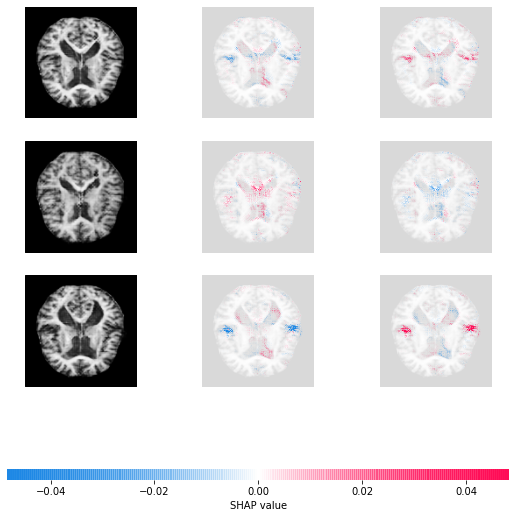

In [11]:
shap_deep_explainer(
    model=synth_model,
    background = images[:100],
    test_images = images[100:103],
)

### explain real model

In [12]:
batch = next(iter(real_test_loader))
images, _ = batch
images = images.to(device)

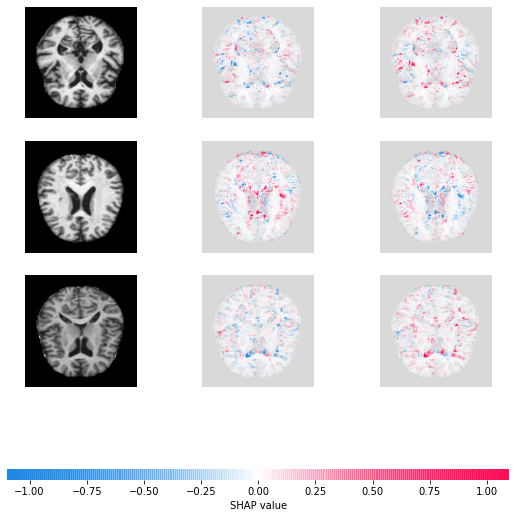

In [13]:
shap_deep_explainer(
    model=real_model,
    background = images[:100],
    test_images = images[100:103],
)